In [3]:
import pandas as pd 
df = pd.read_csv("GamePass_Games.csv", header=1)
print(df.head(5))

                          Game     System xCloud  Status     Added Removed  \
0        Bratz: Rhythm & Style  Xbox / PC    Yes  Active  Dec 2025     NaN   
1              Mortal Kombat 1  Xbox / PC    Yes  Active  Dec 2025     NaN   
2  A Game About Digging A Hole       Xbox    Yes  Active  Dec 2025     NaN   
3                   Death Howl         PC    NaN  Active  Dec 2025     NaN   
4                  Dome Keeper       Xbox    Yes  Active  Dec 2025     NaN   

   Months   Release   Age Metacritic  Completion             Genre Series X|S  \
0    0.27  Sep 2025  0.25        NaN         NaN  Action-Adventure        NaN   
1    0.30  Sep 2023  2.23         83         NaN  Action-Adventure  Exclusive   
2    0.33  Feb 2025  0.84        NaN         2.0         Adventure  Exclusive   
3    0.33  Dec 2025  0.00        NaN         NaN         Adventure        NaN   
4    0.33  Sep 2022  3.20         90         5.0            Action        NaN   

          Owner Notes ESRB ESRB Content Desc

In [5]:
df = df[df["Status"].isin(["Active", "Leaving Soon"])]
df.size


14360

In [ ]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

async def get_game_data_debug(game_name):
    async with async_playwright() as p:
        # 1. Launch Patchright in stealth mode
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_subset.iterrows():
            game_name = row['Game']
            print(f"[{index+1}/10] Investigating: {game_name}")
        # 2. Refined search query for better accuracy
        search_query = clean_game_name(game_name)
        
        # 2. FORCE THE XBOX DOMAIN
        # This tells DuckDuckGo: "Only show me results from the Xbox Store"
        search_url = f"https://duckduckgo.com/?q=site:xbox.com/en-us/games/store+{search_query}"
        
        try:
            print(f"Investigating: {game_name}")
            await page.goto(search_url)
            
            # 3. Wait for the page to settle
            await page.wait_for_timeout(5000) 


            # 5. Use Locator to find the first link that looks like a store result
            # We look for ANY link containing 'xbox.com' to be safe
            result_locator = page.locator('a[href*="xbox.com/en-us/games/store"]').first
            
            store_link = "Not Found"
            product_id = "N/A"

            # Check if the locator actually found something
            if await result_locator.count() > 0:
                store_link = await result_locator.get_attribute("href")
                match = re.search(r"([a-zA-Z0-9]{12})", store_link)
                product_id = match.group(1) if match else "ID Not Found"
            
            await browser.close()
            return store_link, product_id, screenshot_path
            
        except Exception as e:
            print(f"Error: {e}")
            await browser.close()
            return "Error", "N/A", "None"
        
        

# Run a test
# 2. Grab the first 10 rows
df_first_10 = df.head(10)

# 3. Run the scraper
final_results = await scrape_batch(df_first_10)

# 4. Save to a new CSV
results_df = pd.DataFrame(final_results)
results_df.to_csv('xbox_batch_results.csv', index=False)

print("\n--- Batch Complete! ---")
print(results_df)

[1/10] Investigating: Bratz: Rhythm & Style
[2/10] Investigating: Mortal Kombat 1
[3/10] Investigating: A Game About Digging A Hole
[4/10] Investigating: Death Howl
[5/10] Investigating: Dome Keeper
[6/10] Investigating: Routine
[7/10] Investigating: Lost Records: Bloom & Rage
[8/10] Investigating: Marvel Cosmic Invasion
[9/10] Investigating: Banishers: Ghosts of New Eden
[10/10] Investigating: Kill It With Fire! 2

--- Batch Complete! ---
                            Game  \
0          Bratz: Rhythm & Style   
1                Mortal Kombat 1   
2    A Game About Digging A Hole   
3                     Death Howl   
4                    Dome Keeper   
5                        Routine   
6     Lost Records: Bloom & Rage   
7         Marvel Cosmic Invasion   
8  Banishers: Ghosts of New Eden   
9           Kill It With Fire! 2   

                                       MS_Store_Link     ProductID  
0                                          Not Found           N/A  
1                    

In [ ]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import os
import random
from patchright.async_api import async_playwright

nest_asyncio.apply()

async def scrape_batch(df_subset):
    results = []
    
    async with async_playwright() as p:
        # Launch stealth browser
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_subset.iterrows():
            game_name = row['Game']
            print(f"[{index+1}/10] Investigating: {game_name}")
            
            search_url = f"https://duckduckgo.com/?q={game_name}+xbox+store+links"
            
            try:
                await page.goto(search_url)
                # Wait for results to load
                await page.wait_for_timeout(random.randint(7000)) 

                # Grab the first Xbox store link
                result_locator = page.locator('a[href*="xbox.com/en-us/games/store"]').first
                
                store_link = "Not Found"
                product_id = "N/A"

                if await result_locator.count() > 0:
                    store_link = await result_locator.get_attribute("href")
                    # Remove any UTM parameters before regex
                    clean_link = store_link.split('?')[0]
                    match = re.search(r"([a-zA-Z0-9]{12})", clean_link)
                    product_id = match.group(1) if match else "ID Not Found"
                
                results.append({
                    "Game": game_name,
                    "MS_Store_Link": store_link,
                    "ProductID": product_id
                })
                
                # Human-like pause between games
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error for {game_name}: {e}")
                results.append({"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"})

        await browser.close()
    return results





[1/10] Investigating: Bratz: Rhythm & Style
[2/10] Investigating: Mortal Kombat 1
Error for Mortal Kombat 1: Page.wait_for_timeout: Target page, context or browser has been closed
[3/10] Investigating: A Game About Digging A Hole
Error for A Game About Digging A Hole: Page.goto: Target page, context or browser has been closed
[4/10] Investigating: Death Howl
Error for Death Howl: Page.goto: Target page, context or browser has been closed
[5/10] Investigating: Dome Keeper
Error for Dome Keeper: Page.goto: Target page, context or browser has been closed
[6/10] Investigating: Routine
Error for Routine: Page.goto: Target page, context or browser has been closed
[7/10] Investigating: Lost Records: Bloom & Rage
Error for Lost Records: Bloom & Rage: Page.goto: Target page, context or browser has been closed
[8/10] Investigating: Marvel Cosmic Invasion
Error for Marvel Cosmic Invasion: Page.goto: Target page, context or browser has been closed
[9/10] Investigating: Banishers: Ghosts of New Ede

In [8]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

# Helper function to clean names (Fixes the Bratz/Special Char issue)
def clean_game_name(name):
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_subset):
    results = []
    
    # 1. Start Patchright Stealth Browser
    async with async_playwright() as p:
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        # 2. Loop through your 10 games
        for index, row in df_subset.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            
            # 3. Targeted Search Query
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            print(f"[{index+1}/10] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                # Wait for the page to render
                await page.wait_for_timeout(random.randint(4000, 6000)) 

                # 4. Grab the first organic store link
                result_locator = page.locator('a[href*="xbox.com/en-us/games/store"]').first
                
                store_link = "Not Found"
                product_id = "N/A"

                if await result_locator.count() > 0:
                    store_link = await result_locator.get_attribute("href")
                    # Snip the 12-char ID from the clean link
                    clean_link = store_link.split('?')[0]
                    match = re.search(r"([a-zA-Z0-9]{12})", clean_link.strip('/'))
                    product_id = match.group(1) if match else "ID Not Found"
                
                results.append({
                    "Game": game_name,
                    "MS_Store_Link": store_link,
                    "ProductID": product_id
                })
                
                # Human-like pause to prevent IP flagging
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                results.append({"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"})

        await browser.close()
    return results

# --- Main Execution ---
# Make sure your file name matches exactly!
df_first_10 = df.head(10)

# Run the scraper
batch_results = await scrape_xbox_batch(df_first_10)

# Save and View
results_df = pd.DataFrame(batch_results)
results_df.to_csv('xbox_batch_results.csv', index=False)
print("\n--- Batch Complete! ---")
print(results_df)

[1/10] Searching: Bratz: Rhythm & Style
[2/10] Searching: Mortal Kombat 1
[3/10] Searching: A Game About Digging A Hole
[4/10] Searching: Death Howl
[5/10] Searching: Dome Keeper
[6/10] Searching: Routine
[7/10] Searching: Lost Records: Bloom & Rage
[8/10] Searching: Marvel Cosmic Invasion
[9/10] Searching: Banishers: Ghosts of New Eden
[10/10] Searching: Kill It With Fire! 2

--- Batch Complete! ---
                            Game  \
0          Bratz: Rhythm & Style   
1                Mortal Kombat 1   
2    A Game About Digging A Hole   
3                     Death Howl   
4                    Dome Keeper   
5                        Routine   
6     Lost Records: Bloom & Rage   
7         Marvel Cosmic Invasion   
8  Banishers: Ghosts of New Eden   
9           Kill It With Fire! 2   

                                       MS_Store_Link     ProductID  
0  https://www.xbox.com/en-us/games/store/bratz-r...  9p76mmjg50ds  
1                                          Not Found         

In [10]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

def clean_game_name(name):
    """Refines the game title for better search engine matching."""
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_subset):
    results_file = 'xbox_batch_results.csv'
    results = []
    
    async with async_playwright() as p:
        # Patchright stealth browser initialization
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_subset.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            
            # Using the 'site:' operator to force official store results
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            print(f"[{index+1}/{len(df_subset)}] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                # Random wait to mimic human browsing behavior
                await page.wait_for_timeout(random.randint(5000, 7000)) 

                # Extracting all links to find the best match
                all_links = await page.eval_on_selector_all("a", "elements => elements.map(e => e.href)")
                
                store_link = "Not Found"
                product_id = "N/A"

                for link in all_links:
                    if "xbox.com/en-us/games/store/" in link:
                        # Clean tracking parameters before ID extraction
                        clean_link = link.split('?')[0].rstrip('/')
                        match = re.search(r"([a-zA-Z0-9]{12})$", clean_link)
                        
                        if match:
                            store_link = link
                            product_id = match.group(1)
                            break 

                current_result = {
                    "Game": game_name,
                    "MS_Store_Link": store_link,
                    "ProductID": product_id
                }
                results.append(current_result)
                
                # Save-as-you-go: Append this row to the CSV immediately
                pd.DataFrame([current_result]).to_csv(
                    results_file, 
                    mode='a', 
                    index=False, 
                    header=not os.path.exists(results_file)
                )
                
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                error_row = {"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"}
                results.append(error_row)
                pd.DataFrame([error_row]).to_csv(results_file, mode='a', index=False, header=False)

        await browser.close()
    return results

# --- Main Execution ---
# Ensure your CSV is in the same directory or provide the full path
df_first_10 = df.head(10)
await scrape_xbox_batch(df_first_10)
print("\n--- Batch Complete! Results saved to xbox_batch_results.csv ---")

[1/10] Searching: Bratz: Rhythm & Style
[2/10] Searching: Mortal Kombat 1
[3/10] Searching: A Game About Digging A Hole
[4/10] Searching: Death Howl
[5/10] Searching: Dome Keeper
[6/10] Searching: Routine
[7/10] Searching: Lost Records: Bloom & Rage
[8/10] Searching: Marvel Cosmic Invasion
[9/10] Searching: Banishers: Ghosts of New Eden
[10/10] Searching: Kill It With Fire! 2

--- Batch Complete! Results saved to xbox_batch_results.csv ---


In [17]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

# 1. NEW: Logic to reset the file before the loop starts
results_file = 'xbox_batch_results.csv'
if os.path.exists(results_file):
    os.remove(results_file) # Deletes the old file so you start fresh

def clean_game_name(name):
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_subset):
    async with async_playwright() as p:
        # Patchright stealth browser
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            
            # 2. IMPROVED SEARCH: Force results from the official store
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            print(f"[{index+1}/{len(df_subset)}] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                await page.wait_for_timeout(random.randint(5000, 7000)) 

                # Grab all links to ensure we find the right one
                all_links = await page.eval_on_selector_all("a", "elements => elements.map(e => e.href)")
                
                store_link = "Not Found"
                product_id = "N/A"

                for link in all_links:
                    if "xbox.com/en-us/games/store/" in link:
                        clean_link = link.split('?')[0].rstrip('/')
                        match = re.search(r"([a-zA-r0-9]{12})$", clean_link)
                        if match:
                            store_link = link
                            product_id = match.group(1)
                            break 

                current_result = {"Game": game_name, "MS_Store_Link": store_link, "ProductID": product_id}
                
                # Append to file
                pd.DataFrame([current_result]).to_csv(
                    results_file, 
                    mode='a', 
                    index=False, 
                    header=not os.path.exists(results_file)
                )
                
                await asyncio.sleep(random.uniform(2, 4))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                error_row = {"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"}
                pd.DataFrame([error_row]).to_csv(results_file, mode='a', index=False, header=False)

        await browser.close()

# --- Main Execution ---
# 2. Automatically find where you left off
start_index = 0
if os.path.exists(results_file):
    # Count rows in your existing results to find the starting point
    existing_df = pd.read_csv(results_file)
    start_index = len(existing_df)
    print(f"Resuming from row {start_index}...")

# 3. Create a subset of ONLY the remaining games
df_remaining = df.iloc[start_index:]

# 4. Run the scraper on ONLY the remaining rows
await scrape_xbox_batch(df_remaining)

print(f"\nBatch Complete! All results are in {results_file}")


[1/2158] Searching: Bratz: Rhythm & Style
Error on Bratz: Rhythm & Style: Page.wait_for_timeout: Target page, context or browser has been closed
[2/2158] Searching: Mortal Kombat 1
Error on Mortal Kombat 1: Page.goto: Target page, context or browser has been closed
[3/2158] Searching: A Game About Digging A Hole
Error on A Game About Digging A Hole: Page.goto: Target page, context or browser has been closed
[4/2158] Searching: Death Howl
Error on Death Howl: Page.goto: Target page, context or browser has been closed
[5/2158] Searching: Dome Keeper
Error on Dome Keeper: Page.goto: Target page, context or browser has been closed
[6/2158] Searching: Routine
Error on Routine: Page.goto: Target page, context or browser has been closed
[7/2158] Searching: Lost Records: Bloom & Rage
Error on Lost Records: Bloom & Rage: Page.goto: Target page, context or browser has been closed
[8/2158] Searching: Marvel Cosmic Invasion
Error on Marvel Cosmic Invasion: Page.goto: Target page, context or browse

In [24]:
import pandas as pd
import re
import asyncio
import nest_asyncio
import random
import os
from patchright.async_api import async_playwright

nest_asyncio.apply()

# 1. SETUP: Point to your results file
results_file = 'xbox_batch_results.csv'

def clean_game_name(name):
    clean = name.replace("&", "and")
    clean = re.sub(r'[^a-zA-Z0-9\s]', ' ', clean)
    return " ".join(clean.split())

async def scrape_xbox_batch(df_to_scrape):
    async with async_playwright() as p:
        # headless=True keeps this running quietly in the background
        browser = await p.chromium.launch(headless=False) 
        context = await browser.new_context(
            user_agent="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
        )
        page = await context.new_page()

        for index, row in df_to_scrape.iterrows():
            game_name = row['Game']
            clean_name = clean_game_name(game_name)
            search_url = f"https://duckduckgo.com/?q={clean_name}+xbox+store+links"
            
            
            # This uses the index from your original master df
            print(f"[{index+1}] Searching: {game_name}")
            
            try:
                await page.goto(search_url)
                await page.wait_for_timeout(random.randint(4000, 6000)) 

                all_links = await page.eval_on_selector_all("a", "elements => elements.map(e => e.href)")
                store_link, product_id = "Not Found", "N/A"

                for link in all_links:
                    if "xbox.com/en-us/games/store/" in link:
                        clean_link = link.split('?')[0].rstrip('/')
                        match = re.search(r"([a-zA-Z0-9]{12})$", clean_link)
                        if match:
                            store_link, product_id = link, match.group(1)
                            break 

                current_result = {"Game": game_name, "MS_Store_Link": store_link, "ProductID": product_id}
                
                # APPEND: Add to the bottom of the existing file
                pd.DataFrame([current_result]).to_csv(
                    results_file, 
                    mode='a', 
                    index=False, 
                    header=not os.path.exists(results_file) # Header only if file is brand new
                )
                
                await asyncio.sleep(random.uniform(1, 2))
                
            except Exception as e:
                print(f"Error on {game_name}: {e}")
                # Save the error state so you don't keep retrying it on resume
                error_row = {"Game": game_name, "MS_Store_Link": "Error", "ProductID": "N/A"}
                pd.DataFrame([error_row]).to_csv(results_file, mode='a', index=False, header=False)

        await browser.close()

# --- Main Execution (Using your pre-loaded 'df') ---

# 2. Resuming logic: Find out how many rows we already finished
start_index = 0
if os.path.exists(results_file):
    existing_results = pd.read_csv(results_file)
    start_index = len(existing_results)
    print(f"Resuming from index {start_index}...")

# 3. SLICE the existing 'df' to get only what is left
df_remaining = df.iloc[start_index:]

# 4. RUN only if there is work left
if not df_remaining.empty:
    await scrape_xbox_batch(df_remaining)
else:
    print("Dataset already fully scraped.")

print(f"\nDone! Results saved to {results_file}")

Resuming from index 238...
[239] Searching: Zork I: The Great Underground 
[240] Searching: Zork Zero: The Revenge of Megaboz
[241] Searching: Monster Train 2
[242] Searching: DOOM: The Dark Ages
[243] Searching: Firefighting Simulator: The Squad
[244] Searching: Police Simulator: Patrol Officers
[245] Searching: Kulebra and the Souls of Limbo
[246] Searching: Warhammer: Vermintide 2
[247] Searching: Revenge of the Savage Planet
[248] Searching: Dragon Ball Xenoverse 2
[249] Searching: DREDGE
[250] Searching: Anno 1800
[251] Searching: Call of Duty: Modern Warfare II
[252] Searching: Far Cry 4
[253] Searching: Towerborne (Game Preview)
[254] Searching: Clair Obscur: Expedition 33
[255] Searching: The Elder Scrolls IV: Oblivion - Remastered
[256] Searching: Crime Scene Cleaner
[257] Searching: Tempopo
[258] Searching: SpongeBob SquarePants: The Patrick Star Game
[259] Searching: Grand Theft Auto V
[260] Searching: Blue Prince
[261] Searching: NHL 25
[262] Searching: Commandos: Origins
[

Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished exception=TargetClosedError('Target page, context or browser has been closed')>
patchright._impl._errors.TargetClosedError: Target page, context or browser has been closed
Future exception was never retrieved
future: <Future finished ex

[301] Searching: Microsoft Flight Simulator 2024
[302] Searching: Spyro Reignited Trilogy
[303] Searching: Goat Simulator: Remastered
[304] Searching: Starcraft: Remastered
[305] Searching: Starcraft II: Campaign Collection
[306] Searching: Call of Duty: Black Ops 6
[307] Searching: Ashen
[308] Searching: Call of Duty: Warzone
[309] Searching: Donut County
[310] Searching: Mechwarrior 5: Clans
[311] Searching: South Park: The Fractured but Whole
[312] Searching: Inscryption
[313] Searching: Mad Streets
[314] Searching: SIFU
[315] Searching: Legend of Mana (2021)
[316] Searching: Trials of Mana (2020)
[317] Searching: Ara: History Untold
[318] Searching: Frostpunk 2
[319] Searching: Overwatch 2
[320] Searching: Train Sim World 5
[321] Searching: Riders Republic
[322] Searching: Expeditions: A MudRunner Game
[323] Searching: Age of Mythology: Retold
[324] Searching: Star Trucker
[325] Searching: DOOM + DOOM II: Enhanced
[326] Searching: Atlas Fallen: Reign of Sand
[327] Searching: Crash 

In [6]:
DF = pd.read_csv("xbox_batch_results.csv")
DF.merge(df, on="Game", how="right").to_csv('xbox_merged_results.csv', index=False)

In [8]:
df_clean = pd.read_csv('xbox_merged_results.csv')
df_clean = df_clean[df_clean['MS_Store_Link'] != 'Not Found']
df_clean.to_csv('xbox_final_cleaned_results.csv', index=False)

In [8]:
from prepare_data import prepare_games_dataset
from prepare_data import create_tidy_json
print("=" * 80)
print("PREPARING XBOX DATA FOR ANALYSIS")
print("=" * 80)
    
df = prepare_games_dataset("xbox_data_20251224_1937.json")
    
    
 # Step 2: Save as tidy JSON
create_tidy_json(df, "xbox_tidy.json")
    
# Step 3: Also save as CSV for quick review
df.to_csv("xbox_prepared.csv", index=False)
print("✓ Saved to xbox_prepared.csv")



PREPARING XBOX DATA FOR ANALYSIS
📊 Prepared 1389 games with engagement data
   (Excluded 44 games with zero ratings)
✓ Saved 1389 games to xbox_tidy.json
✓ Saved to xbox_prepared.csv


In [11]:
DF_clean = pd.read_csv('xbox_final_cleaned_results.csv')
Final = df.merge(DF_clean, right_on="ProductID", left_on="product_id", how="left")
Final.to_csv('xbox_final_merged_data.csv', index=False)
print("✓ Final merged data saved to xbox_final_merged_data.csv")

✓ Final merged data saved to xbox_final_merged_data.csv


In [ ]:


rating_7d = pd.to_numeric(Final["rating_7_days_avg"], errors='coerce').fillna(0)
rating_30d = pd.to_numeric(Final["rating_30_days_avg"], errors='coerce').fillna(0)
rating_all = pd.to_numeric(Final["rating_alltime_avg"], errors='coerce').fillna(0)



In [4]:

genre_performance = pd.read_csv('Genre_performance.csv')

In [5]:
genre_performance = genre_performance[genre_performance['Genre'] != 'Unknown']
genre_performance = genre_performance[genre_performance['game_count'] > 5]

/var/folders/bh/dh1w_fld0j96ldg4hvhzhdw00000gn/T/ipykernel_31158/1035239243.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


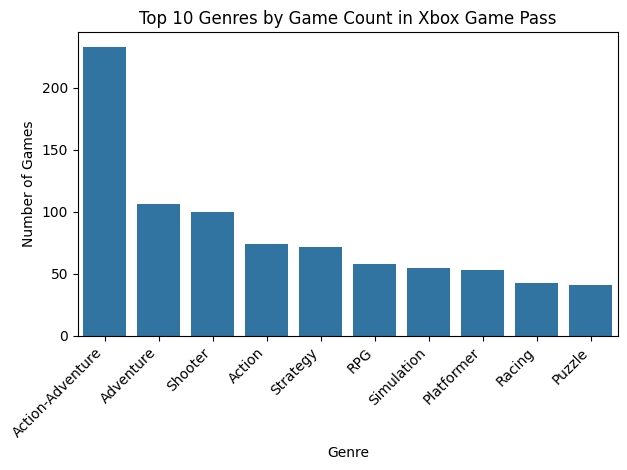

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
genre_performance_10 = genre_performance.sort_values(by='game_count', ascending=False).head(10)
ax = sns.barplot(data=genre_performance_10, x='Genre', y = 'game_count')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Top 10 Genres by Game Count in Xbox Game Pass')
plt.xlabel('Genre')
plt.ylabel('Number of Games')
plt.tight_layout()

/var/folders/bh/dh1w_fld0j96ldg4hvhzhdw00000gn/T/ipykernel_31158/2238269180.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


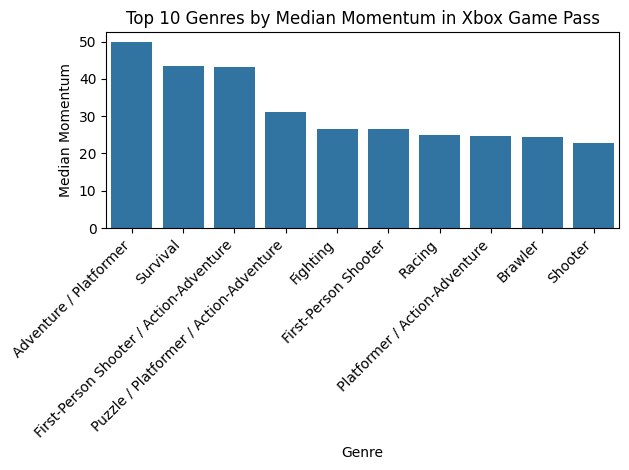

In [9]:
genre_performance_10 = genre_performance.sort_values(by='momentum_median', ascending=False).head(10)
ax = sns.barplot(x='Genre', y='momentum_median', data=genre_performance_10)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.title('Top 10 Genres by Median Momentum in Xbox Game Pass')
plt.xlabel('Genre')
plt.ylabel('Median Momentum')
plt.tight_layout()


In [12]:
genre_gamepass = pd.read_csv('Genre_gamepass_comparison.csv')
genre_gamepass.columns


Index(['Unnamed: 0', 'Unnamed: 1', 'momentum', 'discovery_capture',
       'quality_retention', 'rating_7_days_avg', 'rating_7_days_avg.1',
       'rating_7_days_avg.2', 'rating_30_days_avg', 'rating_30_days_avg.1',
       'rating_30_days_avg.2', 'rating_alltime_avg', 'rating_alltime_avg.1',
       'rating_alltime_avg.2', 'rating_7_days_count', 'rating_7_days_count.1',
       'rating_7_days_count.2', 'rating_30_days_count',
       'rating_30_days_count.1', 'rating_30_days_count.2',
       'rating_alltime_count', 'rating_alltime_count.1',
       'rating_alltime_count.2', 'has_gamepass_remediation', 'game_count'],
      dtype='object')

In [ ]:
sns.relplot(data = genre_gamepass, x='Genre', y='Momentum_median', hue='Game Pass')

In [15]:
df = pd.read_csv("publisher_gamepass_efficiency_fixed.csv")
df.head()

,Unnamed:_0_level_0_Unnamed:_0_level_1,Unnamed:_1_level_0_Unnamed:_1_level_1,momentum_mean,discovery_capture_mean,quality_retention_mean,rating_7_days_avg_mean,rating_7_days_avg_std,rating_7_days_avg_median,rating_30_days_avg_mean,rating_30_days_avg_std,...,rating_7_days_count_std,rating_7_days_count_median,rating_30_days_count_mean,rating_30_days_count_std,rating_30_days_count_median,rating_alltime_count_mean,rating_alltime_count_std,rating_alltime_count_median,has_gamepass_remediation_sum,title_count
0,publisher,has_gamepass_remediation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Art Games Studio S.A.,False,100.000,1.120,-1.100,2.000,NaN,2.0,2.000,NaN,...,NaN,1.0,1.000,NaN,1.0,89.000,NaN,89.0,0.0,1.0
2,10tons Ltd.,False,0.000,0.000,-4.100,0.000,0.000,0.0,0.000,0.000,...,0.000,0.0,0.000,0.000,0.0,254.000,254.558,254.0,0.0,2.0
3,11 bit studios,False,14.582,0.015,-0.600,2.500,2.887,2.5,3.450,2.369,...,0.577,0.5,2.000,1.826,2.0,1986.000,1427.868,2356.5,0.0,4.0
4,11 bit studios,True,5.143,0.940,0.233,2.433,2.205,3.0,4.467,0.462,...,3.786,1.0,46.667,71.445,10.0,1263.333,1964.032,251.0,3.0,3.0
